In my [last post](/2019/05/trading-with-reinforcement-learning-in-python-part-i-gradient-ascent/) we learned how we can use gradient ascent to maximize a reward function. This time, instead of using mean squared error as our reward function, we will use the Sharpe Ratio. By maximizing the Sharpe ratio over a set of training data we can attempt to create a strategy with a high Sharpe ratio when tested on out-of-sample data.

## Sharpe Ratio

The Sharpe ratio is a commonly used indicator to measure the risk adjusted performance of an investment over time. Assuming a risk-free rate of 0, the formula for computing Sharpe ratio is simply the mean returns of the investment divided by the standard deviation of the returns. This can be written as:

$$S_T = {A \over \sqrt{B - A^2}}$$

where $A={1\over T}\sum\limits_{t=1}^{T}R_t$, and $B={1\over T}\sum\limits_{t=1}^{T}R_t^2$

This can be coded in Python like so:

In [4]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

## Trader Function

We know that we will use the Sharpe ratio as our reward function, but how will we know when to trade? We will use the following function to determine our position, $F$, at time $t$:

$$F_t = {\tanh(\theta^T x_t) + 1 \over 2}$$

This function will generate a value between 0 and 1, which will tell us what percentage of the portfolio should buy the asset. $\theta$, like in the last post, will be the parameters we will optimize using gradient ascent, and $x_t$ will be the input vector at time $t$. For this post, we will assign the input vector as $x_t = [1, r_{t - M}, ... , r_t, F_{t - 1}] $, where $r_t$ is the percent change between the asset at time $t$ and $t - 1$, and $M$ is the number of time series inputs. This means that at every time step, the model will be fed its last position and a series of historical price changes that it can use to calculate its next position. We can calculate all of the positions given price series `x`, and `theta` with the following Python function:

In [253]:
import numpy as np

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M: t], [Ft[t - 1]]])
        Ft[t] = 1 + np.tanh(np.dot(theta, xt)) / 2.0
    return Ft

## Calculating Returns

Now that we know what our position will be at each time step, we can calculate our returns $R$ at each time step using the following formula:

$$R_t = (1 + F_{t-1}r_t)(1 - \delta | F_t - F_{t - 1}|) - 1 $$

In this case $\delta$ is our transaction cost rate. We can code this as a function in Python like so:

In [536]:
def returns(Ft, x, delta):
    T = len(x)
    Rt = np.zeros(T)
    for i in range(1, T):
        rt = x[i] / x[i - 1] - 1
        Rt[i] = (
            (1 + Ft[i - 1] * rt) *
            (1 - delta * np.abs(Ft[i] - Ft[i - 1]))
        ) - 1
    return Rt

These returns can then be used to calculate our Sharpe ratio.

# Gradient Ascent

## Determining the Gradient

In order to perform gradient ascent, we must compute the derivative of the Sharpe ratio with respect to theta, or ${dS_T}\over{d\theta}$ Using the chain rule and the above formulas we can write it as:

$${{dS_T}\over{d\theta}} = \sum\limits_{t=1}^{T} ( {{dS_T}\over{dA}}{{dA}\over{dR_t}} + {{dS_T}\over{dB}}{{dB}\over{dR_t}}) \cdot ({{dR_t}\over{dF_t}}{{dF}\over{d\theta}} + {{dR_t}\over{dF_{t-1}}}{{dF_{t-1}}\over{d\theta}})$$

*For all of the steps to compute the above derivative as well as the partial derivatives, see Gabriel Molina's paper, [Stock Trading with Recurrent Reinforcement Learning (RRL)](http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf).* We can compute this derivative in our `gradient` function:

In [537]:
def gradient(x, theta, delta):
    Ft = positions(x, theta)
    rets = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(rets)
    B = np.mean(np.square(rets))
    S = A / np.sqrt(B - A ** 2)
    dSdA = S * (1 + S ** 2) / A
    dSdB = -0.5 * (S ** 3) / (A ** 2)
    dAdR = 1.0 / len(rets)
    dBdR = 2.0 * rets / len(rets)
    
    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        rt = x[t] / x[t - 1] - 1
        dRdF = np.sign(Ft[t-1] - Ft[t]) * delta * (1 + Ft[t - 1] * rt)
        dRdFp = rt * (1.0 - delta * np.abs(Ft[t] - Ft[t - 1])) - dRdF
        dFdtheta = (1.0 - Ft[t] ** 2) * xt
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        dFpdtheta = dFdtheta
        grad += dSdtheta
        
    return grad, sharpe_ratio(rets)

## Training

Now that we have our gradient function, we can optimize our parameters using gradient ascent. Like the last post, we will update our $\theta$ each epoch using $\theta = \theta + \alpha{dS_T \over d\theta}$, where $\alpha$ is our learning rate.

In [538]:
def train(x, epochs=500, M=7, commission=0.0025, learning_rate = 0.1):
    theta = np.ones(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta += grad * learning_rate
        #print(sharpe)
        sharpes[i] = sharpe
    
    
    print("finished training")
    return theta, sharpes

# Trading with Bitcoin

Now that we have our model, let's test it using historical bitcoin data. I will be using a history of all bitcoin transactions on the Bitstamp exchange, downloaded from [bitcoincharts.com](https://api.bitcoincharts.com/v1/csv/). First we'll load the data in and re-sample it to have a frequency of 10 min. We'll then smooth the data with a rolling mean:

In [807]:
import pandas as pd
btc = pd.read_csv("bitstampUSD.csv", names=["utc", "price", "volume"]).set_index('utc')
btc.index = pd.to_datetime(btc.index, unit='s')
rets = btc.resample('10min', label="right").mean()['price'].rolling(10).mean()
rets = rets[~rets.isna()]


Now we'll take the last 500 prices, normalize them, and split into training and testing data:

In [819]:
x = np.array(rets[-500:])
x = (x - np.mean(x)) / np.std(x)

# 50/50 train/test split
x_train = x[:int(.5 * len(x))]
x_test = x[int(.5 * len(x)):]

Now we're ready to train! We'll give the model a look-back window of 5.

In [832]:
theta, sharpes = train(x_train, epochs=1000, M=5, learning_rate=.03)

finished training


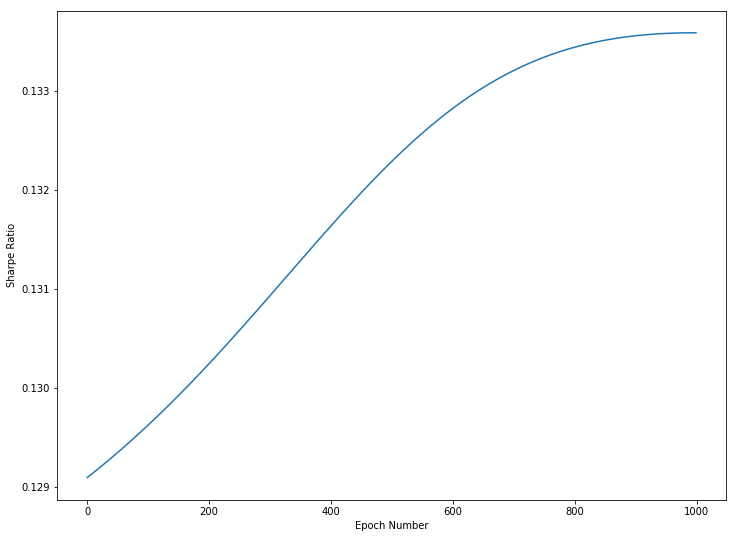

In [834]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

We can see that as the model trains, it converges towards a maximum Sharpe Ratio. Lets see how the model performed over the training data:

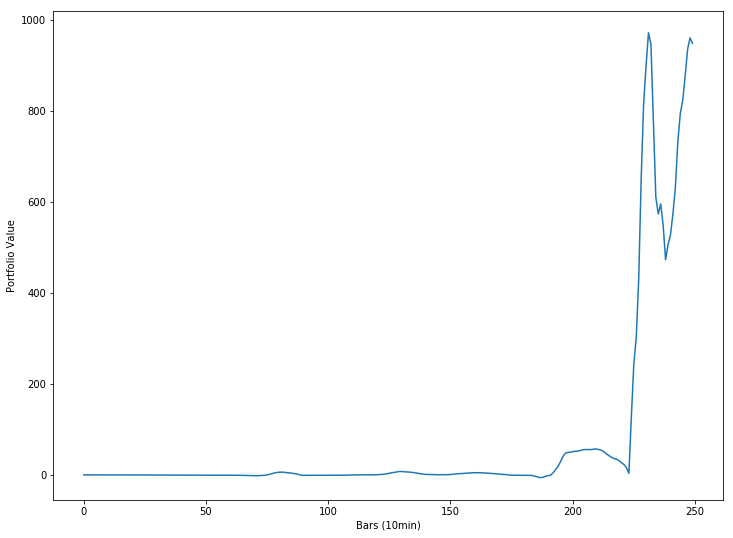

In [833]:
pos = positions(x_train, theta)
train_returns = returns(pos, x_train, 0.0025)
plt.plot((train_returns + 1).cumprod())
plt.xlabel('Bars (10min)')
plt.ylabel('Portfolio Value');

The model managed to turn $1 into almost $1000, but lost almost half of it. Overall the performance looks very volatile. Lets see how it performs over the testing data:

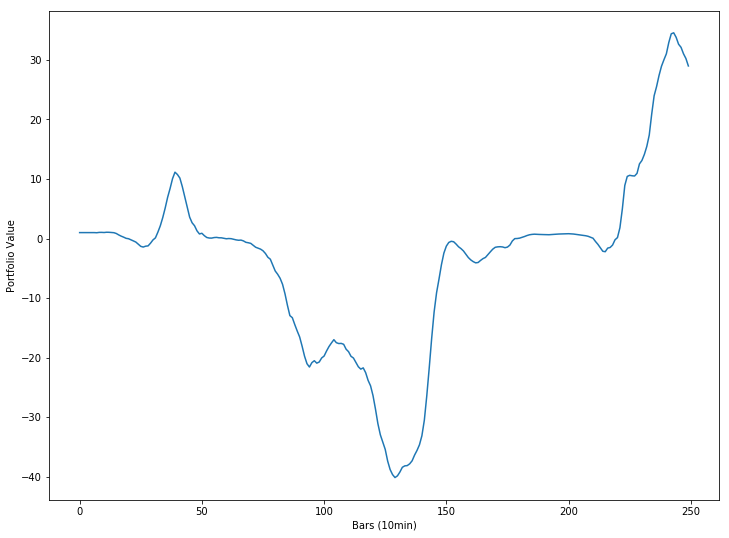

In [837]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((test_returns + 1).cumprod())
plt.xlabel('Bars (10min)')
plt.ylabel('Portfolio Value');

The performance is even worse! This model might have over-fit for the training data, or the market may have been behaving differently than the training set. Overall this model is very simplistic, and one cannot expect great performance out of it without providing more parameters, adjusting the reward function, and possibly altering the trading function. This strategy serves as a good example of how reinforcement learning with gradient ascent could have merit with further development. For more literature on reinforcement learning stock trading strategies, I recommend these papers:
* [Reinforcement Learning for Trading](http://papers.nips.cc/paper/1551-reinforcement-learning-for-trading.pdf)
* [Stock Trading with Recurrent Reinforcement Learning](http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf)